# Crude Oil Price Prediction Experiment
## Model: CNN-LSTM
## Interval: 5-minute

This experiment explores the use of a hybrid CNN-LSTM architecture for predicting crude oil price movements on a 5-minute interval.

### 1. Data Loading

We load the 5-minute crude oil price data from `../../data/crude_5m.csv`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import os

print("TensorFlow version:", tf.__version__)

# Load data
csv_path = '../../data/crude_5m.csv'
if not os.path.exists(csv_path):
    print(f"Error: {csv_path} not found.")
else:
    # Skip the multi-line headers discovered in the CSV
    df = pd.read_csv(csv_path, skiprows=3, names=['Datetime', 'Close', 'High', 'Low', 'Open', 'Volume'])
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    df.set_index('Datetime', inplace=True)
    
    # Ensure all columns are numeric
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    df.dropna(inplace=True)
    print("Data loaded and cleaned. Shape:", df.shape)
    display(df.head())

TensorFlow version: 2.19.0


Data loaded and cleaned. Shape: (5319, 5)


,Close,High,Low,Open,Volume
Datetime,,,,,
2026-01-11 23:10:00+00:00,59.590000,59.630001,59.459999,59.529999,665
2026-01-11 23:15:00+00:00,59.610001,59.660000,59.570000,59.599998,550
2026-01-11 23:20:00+00:00,59.610001,59.639999,59.570000,59.619999,338
2026-01-11 23:25:00+00:00,59.630001,59.650002,59.570000,59.610001,396
2026-01-11 23:30:00+00:00,59.590000,59.639999,59.529999,59.639999,434


### 2. Feature Engineering

We calculate technical features and handle missing values.

In [2]:
# Calculate features
df['log_ret'] = np.log(df['Close'] / df['Close'].shift(1))
df['hl_range'] = df['High'] - df['Low']
df['co_range'] = df['Close'] - df['Open']
df['volatility'] = df['log_ret'].rolling(window=14).std()
df['volume_pct'] = df['Volume'].pct_change()

# RSI (14 period)
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['rsi'] = 100 - (100 / (1 + rs))

# MACD (12, 26, 9)
ema12 = df['Close'].ewm(span=12, adjust=False).mean()
ema26 = df['Close'].ewm(span=26, adjust=False).mean()
df['macd'] = ema12 - ema26
df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()

# Handle inf values (e.g., from volume_pct)
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop NaNs created by shift/rolling/pct_change/inf replacement
feature_cols = ['log_ret', 'hl_range', 'co_range', 'volatility', 'volume_pct', 'rsi', 'macd', 'macd_signal']
df_features = df[feature_cols].dropna()

print("Features calculated. Shape after dropping NaNs:", df_features.shape)
display(df_features.head())

Features calculated. Shape after dropping NaNs: (5289, 8)


,log_ret,hl_range,co_range,volatility,volume_pct,rsi,macd,macd_signal
Datetime,,,,,,,,
2026-01-12 00:20:00+00:00,-0.000337,0.060001,-0.029999,0.001075,0.107692,37.142919,-0.041841,-0.014840
2026-01-12 00:25:00+00:00,-0.000842,0.050003,-0.040001,0.001074,-0.274306,32.876791,-0.050795,-0.022031
2026-01-12 00:30:00+00:00,0.000168,0.050003,0.009998,0.001079,-0.440191,33.783707,-0.056434,-0.028911
2026-01-12 00:35:00+00:00,0.000168,0.029999,0.010002,0.001072,0.803419,32.876791,-0.059411,-0.035011
2026-01-12 00:40:00+00:00,0.000505,0.079998,0.029999,0.001087,0.298578,37.500000,-0.058673,-0.039744


### 3. Scaling and Data Splitting

We scale the features and split the data into training, validation, and test sets.

In [3]:
from sklearn.preprocessing import RobustScaler
# Scale features
scaler = RobustScaler()
scaled_features = scaler.fit_transform(df_features)
df_scaled = pd.DataFrame(scaled_features, index=df_features.index, columns=df_features.columns)

# Time-based split (70% train, 15% val, 15% test)
n = len(df_scaled)
train_df = df_scaled.iloc[0:int(n*0.7)]
val_df = df_scaled.iloc[int(n*0.7):int(n*0.85)]
test_df = df_scaled.iloc[int(n*0.85):]

print(f"Split sizes: Train {len(train_df)}, Val {len(val_df)}, Test {len(test_df)}")

Split sizes: Train 3702, Val 793, Test 794


### 4. Sliding Windows and Labels

We create 24-step windows for the temporal sequence.

In [4]:
def create_windows(data_df, full_df, window_size=24):
    X = []
    y = []
    
    # Get prices for labels (matched index)
    closes = full_df.loc[data_df.index, 'Close'].values
    feature_values = data_df.values
    
    for i in range(len(data_df) - window_size):
        X.append(feature_values[i : i + window_size])
        # Binary label: 1 if next close > current close, else 0
        if i + window_size < len(closes):
            if closes[i + window_size] > closes[i + window_size - 1]:
                y.append(1)
            else:
                y.append(0)
            
    return np.array(X), np.array(y).reshape(-1, 1)

window_size = 60
X_train, y_train = create_windows(train_df, df, window_size)
X_val, y_val = create_windows(val_df, df, window_size)
X_test, y_test = create_windows(test_df, df, window_size)

print("Window shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)
print("Label distribution (UP ratio) in Training:", np.mean(y_train))

Window shapes:
X_train: (3642, 60, 8) y_train: (3642, 1)
X_val: (733, 60, 8) y_val: (733, 1)
X_test: (734, 60, 8) y_test: (734, 1)
Label distribution (UP ratio) in Training: 0.4785831960461285


### 5. CNN-LSTM Model Architecture

The model combines convolution for pattern detection and LSTM for temporal sequence modeling.

In [5]:
model = Sequential([
    # CNN part: Temporal pattern extraction
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, X_train.shape[2])),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    
    # LSTM part: Sequence processing
    LSTM(100, return_sequences=True),
    Dropout(0.3),
    LSTM(50, return_sequences=False),
    Dropout(0.3),
    
    # Dense part: Classification output
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

C:\Users\tanishka\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                   ┃ Output Shape           ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                │ (None, 58, 64)         │        1,600 │
├────────────────────────────────┼────────────────────────┼──────────────┤
│ batch_normalization            │ (None, 58, 64)         │          256 │
│ (BatchNormalization)           │                        │              │
├────────────────────────────────┼────────────────────────┼──────────────┤
│ max_pooling1d (MaxPooling1D)   │ (None, 29, 64)         │            0 │
├────────────────────────────────┼────────────────────────┼──────────────┤
│ dropout (Dropout)              │ (None, 29, 64)         │            0 │
├────────────────────────────────┼────────────────────────┼──────────────┤
│ lstm (LSTM)                    │ (None, 29, 100)        │       66,000 │
├────────────────────────────────┼────────────────────────┼──────────────┤
│ dropout_1 (Dropout)            │ (None, 29, 100)        │            0 │
├────────────────────────────────┼────────────────────────┼──────────────┤
│ lstm_1 (LSTM)                  │ (None, 50)             │       30,200 │
├────────────────────────────────┼────────────────────────┼──────────────┤
│ dropout_2 (Dropout)            │ (None, 50)             │            0 │
├────────────────────────────────┼────────────────────────┼──────────────┤
│ dense (Dense)                  │ (None, 64)             │        3,264 │
├────────────────────────────────┼────────────────────────┼──────────────┤
│ dropout_3 (Dropout)            │ (None, 64)             │            0 │
├────────────────────────────────┼────────────────────────┼──────────────┤
│ dense_1 (Dense)                │ (None, 32)             │        2,080 │
├────────────────────────────────┼────────────────────────┼──────────────┤
│ dense_2 (Dense)                │ (None, 1)              │           33 │
└────────────────────────────────┴────────────────────────┴──────────────┘

 Total params: 103,433 (404.04 KB)

 Trainable params: 103,305 (403.54 KB)

 Non-trainable params: 128 (512.00 B)

### 6. Model Training

We use EarlyStopping and ModelCheckpoint to prevent overfitting.

In [6]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
]

print("Starting training...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Starting training...
Epoch 1/50


  1/114 ━━━━━━━━━━━━━━━━━━━━ 13:32 7s/step - accuracy: 0.4688 - loss: 0.6903

  2/114 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - accuracy: 0.4609 - loss: 0.6936 

  3/114 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.4635 - loss: 0.6949

  5/114 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.4691 - loss: 0.6952

  7/114 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.4744 - loss: 0.6955

  9/114 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.4760 - loss: 0.6959

 11/114 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.4749 - loss: 0.6963

 13/114 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.4755 - loss: 0.6964

 15/114 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.4746 - loss: 0.6966

 17/114 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.4747 - loss: 0.6967

 19/114 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.4756 - loss: 0.6966

 21/114 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.4768 - loss: 0.6965

 23/114 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.4783 - loss: 0.6964

 25/114 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.4796 - loss: 0.6963

 28/114 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.4815 - loss: 0.6962

 31/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.4827 - loss: 0.6960

 33/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.4835 - loss: 0.6959

 36/114 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.4846 - loss: 0.6957

 39/114 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.4858 - loss: 0.6956

 42/114 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.4871 - loss: 0.6955

 45/114 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.4882 - loss: 0.6954

 48/114 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.4890 - loss: 0.6953

 51/114 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.4897 - loss: 0.6952

 53/114 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.4902 - loss: 0.6952

 55/114 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.4906 - loss: 0.6951

 57/114 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.4910 - loss: 0.6951

 59/114 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.4914 - loss: 0.6950

 61/114 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.4918 - loss: 0.6950

 63/114 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.4922 - loss: 0.6949

 65/114 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.4925 - loss: 0.6949

 67/114 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.4927 - loss: 0.6949

 69/114 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.4929 - loss: 0.6948

 72/114 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.4932 - loss: 0.6948

 74/114 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.4935 - loss: 0.6948

 76/114 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.4938 - loss: 0.6948

 78/114 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.4941 - loss: 0.6947

 80/114 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4943 - loss: 0.6947

 82/114 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4945 - loss: 0.6947

 85/114 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4948 - loss: 0.6947

 88/114 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4951 - loss: 0.6947

 91/114 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4954 - loss: 0.6947

 93/114 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4957 - loss: 0.6947

 95/114 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4959 - loss: 0.6947

 97/114 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4962 - loss: 0.6947

 99/114 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4964 - loss: 0.6946

101/114 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4966 - loss: 0.6946

103/114 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4968 - loss: 0.6946

105/114 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4969 - loss: 0.6946

107/114 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4971 - loss: 0.6946

109/114 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4973 - loss: 0.6946

111/114 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4975 - loss: 0.6946

113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4976 - loss: 0.6946

114/114 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - accuracy: 0.4978 - loss: 0.6946 - val_accuracy: 0.5171 - val_loss: 0.6920


Epoch 2/50


  1/114 ━━━━━━━━━━━━━━━━━━━━ 47s 424ms/step - accuracy: 0.6250 - loss: 0.6882

  3/114 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.5469 - loss: 0.6909  

  5/114 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.5281 - loss: 0.6924

  7/114 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.5236 - loss: 0.6932

  9/114 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.5215 - loss: 0.6933

 11/114 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.5233 - loss: 0.6933

 13/114 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.5253 - loss: 0.6930

 15/114 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.5265 - loss: 0.6927

 17/114 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5275 - loss: 0.6924

 19/114 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5288 - loss: 0.6921

 21/114 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5297 - loss: 0.6918

 23/114 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5305 - loss: 0.6915

 25/114 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5316 - loss: 0.6912

 27/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5329 - loss: 0.6910

 29/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5336 - loss: 0.6909

 31/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5343 - loss: 0.6907

 33/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5352 - loss: 0.6905

 35/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5361 - loss: 0.6904

 37/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5369 - loss: 0.6902

 39/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5374 - loss: 0.6901

 41/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5377 - loss: 0.6901

 43/114 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5380 - loss: 0.6901

 45/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5383 - loss: 0.6901

 47/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5386 - loss: 0.6900

 49/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5391 - loss: 0.6900

 51/114 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5395 - loss: 0.6899

 53/114 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5399 - loss: 0.6899

 55/114 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5401 - loss: 0.6899

 57/114 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5402 - loss: 0.6899

 59/114 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5402 - loss: 0.6899

 61/114 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5402 - loss: 0.6899

 63/114 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5401 - loss: 0.6900

 65/114 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5399 - loss: 0.6900

 67/114 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5397 - loss: 0.6900

 69/114 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5396 - loss: 0.6901

 71/114 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5394 - loss: 0.6901

 73/114 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5392 - loss: 0.6901

 75/114 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5390 - loss: 0.6902

 77/114 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5388 - loss: 0.6902

 79/114 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5386 - loss: 0.6903

 81/114 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5383 - loss: 0.6903

 83/114 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5381 - loss: 0.6904

 85/114 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5379 - loss: 0.6904

 87/114 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5378 - loss: 0.6904

 89/114 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5377 - loss: 0.6905

 91/114 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5376 - loss: 0.6905

 93/114 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5375 - loss: 0.6905

 95/114 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5374 - loss: 0.6905

 97/114 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5372 - loss: 0.6906

 99/114 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5371 - loss: 0.6906

101/114 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5370 - loss: 0.6906

103/114 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5369 - loss: 0.6907

105/114 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5367 - loss: 0.6907

107/114 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5366 - loss: 0.6907

109/114 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5365 - loss: 0.6908

111/114 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5364 - loss: 0.6908

113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5363 - loss: 0.6908

114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.5363 - loss: 0.6909 - val_accuracy: 0.5307 - val_loss: 0.6915


Epoch 3/50


  1/114 ━━━━━━━━━━━━━━━━━━━━ 2:23 1s/step - accuracy: 0.5938 - loss: 0.6913

  3/114 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.5330 - loss: 0.6910

  5/114 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.5073 - loss: 0.6928

  7/114 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.4998 - loss: 0.6933

  9/114 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.4936 - loss: 0.6936

 11/114 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.4920 - loss: 0.6938

 13/114 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.4906 - loss: 0.6938

 15/114 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.4905 - loss: 0.6937

 17/114 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.4906 - loss: 0.6936

 19/114 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.4904 - loss: 0.6936

 21/114 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.4909 - loss: 0.6934

 23/114 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.4907 - loss: 0.6933

 25/114 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.4905 - loss: 0.6934

 27/114 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.4905 - loss: 0.6934

 29/114 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.4906 - loss: 0.6934

 31/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.4911 - loss: 0.6933

 33/114 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.4918 - loss: 0.6933

 35/114 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.4925 - loss: 0.6932

 37/114 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.4933 - loss: 0.6931

 39/114 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.4941 - loss: 0.6930

 41/114 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.4948 - loss: 0.6929

 43/114 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.4957 - loss: 0.6929

 45/114 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.4966 - loss: 0.6928

 47/114 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.4977 - loss: 0.6927

 49/114 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.4988 - loss: 0.6926

 51/114 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.4998 - loss: 0.6925

 53/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5008 - loss: 0.6924

 55/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5016 - loss: 0.6923

 57/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5024 - loss: 0.6922

 59/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5031 - loss: 0.6922

 61/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5037 - loss: 0.6921

 63/114 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5043 - loss: 0.6920

 65/114 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5048 - loss: 0.6920

 67/114 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5052 - loss: 0.6919

 69/114 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5056 - loss: 0.6919

 71/114 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5060 - loss: 0.6919

 73/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5064 - loss: 0.6918

 75/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5067 - loss: 0.6918

 76/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5068 - loss: 0.6918

 78/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5071 - loss: 0.6917

 80/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5073 - loss: 0.6917

 82/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5075 - loss: 0.6917

 84/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5077 - loss: 0.6916

 86/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5079 - loss: 0.6916

 88/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5081 - loss: 0.6916

 90/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5082 - loss: 0.6916

 92/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5084 - loss: 0.6916

 94/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5085 - loss: 0.6916

 96/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5086 - loss: 0.6916

 98/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5087 - loss: 0.6915

100/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5088 - loss: 0.6915

102/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5089 - loss: 0.6915

104/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5089 - loss: 0.6915

106/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5090 - loss: 0.6915

108/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5091 - loss: 0.6915

110/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5091 - loss: 0.6915

112/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5092 - loss: 0.6915

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5092 - loss: 0.6915

114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.5093 - loss: 0.6915 - val_accuracy: 0.5280 - val_loss: 0.6910


Epoch 4/50


  1/114 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 0.5938 - loss: 0.6901

  3/114 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.5851 - loss: 0.6861

  5/114 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.5782 - loss: 0.6870

  7/114 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5829 - loss: 0.6868

  9/114 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5796 - loss: 0.6875

 11/114 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.5735 - loss: 0.6881

 13/114 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.5681 - loss: 0.6886

 15/114 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.5654 - loss: 0.6889

 17/114 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.5621 - loss: 0.6891

 19/114 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.5597 - loss: 0.6893

 21/114 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.5581 - loss: 0.6895

 23/114 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5563 - loss: 0.6897

 25/114 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5550 - loss: 0.6898

 27/114 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5533 - loss: 0.6899

 29/114 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5519 - loss: 0.6901

 31/114 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5507 - loss: 0.6902

 33/114 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5496 - loss: 0.6902

 35/114 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5489 - loss: 0.6903

 37/114 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5481 - loss: 0.6904

 39/114 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5476 - loss: 0.6904

 41/114 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5474 - loss: 0.6904

 43/114 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5473 - loss: 0.6904

 45/114 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5472 - loss: 0.6904

 47/114 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5470 - loss: 0.6904

 49/114 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5469 - loss: 0.6904

 51/114 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5468 - loss: 0.6904

 53/114 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5465 - loss: 0.6905

 55/114 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5463 - loss: 0.6905

 57/114 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5462 - loss: 0.6905

 59/114 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5460 - loss: 0.6905

 61/114 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5457 - loss: 0.6906

 63/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5454 - loss: 0.6906

 65/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5451 - loss: 0.6907

 67/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5448 - loss: 0.6907

 69/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5446 - loss: 0.6907

 71/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5444 - loss: 0.6908

 73/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5441 - loss: 0.6908

 75/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5439 - loss: 0.6908

 77/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5436 - loss: 0.6909

 79/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5434 - loss: 0.6909

 81/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5431 - loss: 0.6909

 83/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5429 - loss: 0.6909

 85/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5426 - loss: 0.6910

 87/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5424 - loss: 0.6910

 89/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5422 - loss: 0.6910

 91/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5419 - loss: 0.6910

 93/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5418 - loss: 0.6910

 95/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5416 - loss: 0.6911

 97/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5414 - loss: 0.6911

 99/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5412 - loss: 0.6911

101/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5410 - loss: 0.6911

103/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5408 - loss: 0.6911

105/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5407 - loss: 0.6911

107/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5406 - loss: 0.6911

109/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5404 - loss: 0.6912

111/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5403 - loss: 0.6912

113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5401 - loss: 0.6912

114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.5400 - loss: 0.6912 - val_accuracy: 0.5198 - val_loss: 0.6936


Epoch 5/50


  1/114 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.5000 - loss: 0.6896

  3/114 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.5486 - loss: 0.6828

  5/114 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.5676 - loss: 0.6810

  7/114 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.5691 - loss: 0.6819

  9/114 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.5677 - loss: 0.6830

 11/114 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.5659 - loss: 0.6840

 13/114 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.5640 - loss: 0.6848

 15/114 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.5617 - loss: 0.6855

 17/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5583 - loss: 0.6862

 19/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5552 - loss: 0.6869

 21/114 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5521 - loss: 0.6876

 23/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5495 - loss: 0.6881

 25/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5478 - loss: 0.6885

 27/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5470 - loss: 0.6886

 29/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5462 - loss: 0.6888

 31/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5454 - loss: 0.6890

 33/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5448 - loss: 0.6891

 35/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5443 - loss: 0.6893

 37/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5441 - loss: 0.6893

 39/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5441 - loss: 0.6893

 41/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5442 - loss: 0.6893

 43/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5442 - loss: 0.6893

 45/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5441 - loss: 0.6894

 47/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5439 - loss: 0.6894

 49/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5436 - loss: 0.6895

 51/114 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5432 - loss: 0.6896

 53/114 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5429 - loss: 0.6897

 55/114 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5426 - loss: 0.6897

 57/114 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5423 - loss: 0.6898

 59/114 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5419 - loss: 0.6898

 61/114 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5416 - loss: 0.6899

 63/114 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5412 - loss: 0.6899

 65/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5411 - loss: 0.6899

 67/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5408 - loss: 0.6899

 69/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5406 - loss: 0.6900

 71/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5403 - loss: 0.6900

 73/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5401 - loss: 0.6900

 75/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5398 - loss: 0.6901

 77/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5395 - loss: 0.6901

 79/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5391 - loss: 0.6902

 81/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5388 - loss: 0.6902

 83/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5386 - loss: 0.6903

 85/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5384 - loss: 0.6903

 87/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5381 - loss: 0.6904

 89/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5379 - loss: 0.6904

 91/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5376 - loss: 0.6905

 93/114 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5373 - loss: 0.6905

 95/114 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5370 - loss: 0.6905

 97/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5368 - loss: 0.6906

 99/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5365 - loss: 0.6906

101/114 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5362 - loss: 0.6907

103/114 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5359 - loss: 0.6907

105/114 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5356 - loss: 0.6907

107/114 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5353 - loss: 0.6908

109/114 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5351 - loss: 0.6908

111/114 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5349 - loss: 0.6909

113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5347 - loss: 0.6909

114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.5344 - loss: 0.6909 - val_accuracy: 0.5321 - val_loss: 0.6899


Epoch 6/50


  1/114 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 0.6250 - loss: 0.6765

  3/114 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.5938 - loss: 0.6792

  5/114 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.5741 - loss: 0.6815

  7/114 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.5660 - loss: 0.6829

  9/114 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.5631 - loss: 0.6835

 11/114 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.5611 - loss: 0.6842

 13/114 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.5588 - loss: 0.6847

 14/114 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5579 - loss: 0.6848

 16/114 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5570 - loss: 0.6851

 18/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5565 - loss: 0.6852

 20/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5565 - loss: 0.6853

 22/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5566 - loss: 0.6854

 24/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5559 - loss: 0.6856

 26/114 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5555 - loss: 0.6858

 28/114 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5551 - loss: 0.6860

 30/114 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5548 - loss: 0.6861

 32/114 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5543 - loss: 0.6863

 34/114 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5542 - loss: 0.6863

 36/114 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5543 - loss: 0.6864

 38/114 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5541 - loss: 0.6864

 40/114 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5537 - loss: 0.6865

 42/114 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.5533 - loss: 0.6866

 44/114 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5528 - loss: 0.6867

 46/114 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5523 - loss: 0.6868

 48/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5518 - loss: 0.6869

 50/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5513 - loss: 0.6870

 52/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5509 - loss: 0.6871

 54/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5506 - loss: 0.6872

 56/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5504 - loss: 0.6873

 58/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5500 - loss: 0.6874

 60/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5496 - loss: 0.6875

 62/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5492 - loss: 0.6876

 64/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5488 - loss: 0.6877

 66/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5484 - loss: 0.6878

 68/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5480 - loss: 0.6879

 70/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5476 - loss: 0.6879

 72/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5473 - loss: 0.6880

 74/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5470 - loss: 0.6881

 76/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5466 - loss: 0.6882

 78/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5464 - loss: 0.6882

 80/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5461 - loss: 0.6883

 82/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5458 - loss: 0.6883

 84/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5455 - loss: 0.6884

 86/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5452 - loss: 0.6885

 88/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5450 - loss: 0.6885

 90/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5447 - loss: 0.6886

 92/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5445 - loss: 0.6886

 94/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5443 - loss: 0.6887

 96/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5440 - loss: 0.6887

 98/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5438 - loss: 0.6888

100/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5436 - loss: 0.6888

102/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5433 - loss: 0.6889

104/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5432 - loss: 0.6889

106/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5430 - loss: 0.6889

108/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5428 - loss: 0.6890

110/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5427 - loss: 0.6890

112/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5425 - loss: 0.6890

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5423 - loss: 0.6891

114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.5423 - loss: 0.6891 - val_accuracy: 0.5293 - val_loss: 0.6899


Epoch 7/50


  1/114 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.6562 - loss: 0.6720

  3/114 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.6146 - loss: 0.6775

  5/114 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.5913 - loss: 0.6805

  7/114 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.5808 - loss: 0.6823

  9/114 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.5801 - loss: 0.6828

 11/114 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.5777 - loss: 0.6835

 13/114 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5729 - loss: 0.6843

 15/114 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.5705 - loss: 0.6845

 16/114 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.5696 - loss: 0.6846

 18/114 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5675 - loss: 0.6848

 20/114 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5660 - loss: 0.6851

 22/114 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5640 - loss: 0.6856

 24/114 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5620 - loss: 0.6861

 26/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5611 - loss: 0.6864

 28/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5609 - loss: 0.6866

 30/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5605 - loss: 0.6868

 32/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5603 - loss: 0.6869

 34/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5598 - loss: 0.6871

 36/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5593 - loss: 0.6872

 38/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5586 - loss: 0.6874

 40/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5580 - loss: 0.6875

 42/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5573 - loss: 0.6876

 44/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5568 - loss: 0.6877

 46/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5561 - loss: 0.6878

 48/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5554 - loss: 0.6880

 50/114 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5547 - loss: 0.6881

 52/114 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5540 - loss: 0.6882

 54/114 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5534 - loss: 0.6883

 56/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5527 - loss: 0.6885

 58/114 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5520 - loss: 0.6886

 60/114 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5514 - loss: 0.6887

 62/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5509 - loss: 0.6888

 64/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5504 - loss: 0.6888

 66/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5499 - loss: 0.6889

 68/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5496 - loss: 0.6889

 70/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5492 - loss: 0.6890

 72/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5489 - loss: 0.6890

 74/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5486 - loss: 0.6890

 76/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5483 - loss: 0.6891

 78/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5480 - loss: 0.6891

 80/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5477 - loss: 0.6891

 82/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5474 - loss: 0.6891

 84/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5471 - loss: 0.6892

 86/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5467 - loss: 0.6892

 88/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5463 - loss: 0.6893

 90/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5460 - loss: 0.6893

 92/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5456 - loss: 0.6893

 94/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5454 - loss: 0.6894

 96/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5451 - loss: 0.6894

 98/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5449 - loss: 0.6894

100/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5446 - loss: 0.6894

102/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5444 - loss: 0.6895

104/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5442 - loss: 0.6895

106/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5439 - loss: 0.6895

108/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5436 - loss: 0.6895

110/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5433 - loss: 0.6896

112/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5430 - loss: 0.6896

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5428 - loss: 0.6896

114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.5426 - loss: 0.6897 - val_accuracy: 0.5280 - val_loss: 0.6908


Epoch 8/50


  1/114 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - accuracy: 0.5938 - loss: 0.6835

  3/114 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.6319 - loss: 0.6803

  5/114 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.6201 - loss: 0.6815

  7/114 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.6186 - loss: 0.6811

  9/114 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.6135 - loss: 0.6815

 11/114 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.6073 - loss: 0.6824

 13/114 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.6002 - loss: 0.6831

 15/114 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5953 - loss: 0.6836

 17/114 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.5913 - loss: 0.6840

 19/114 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.5883 - loss: 0.6844

 21/114 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.5849 - loss: 0.6848

 23/114 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.5821 - loss: 0.6851

 25/114 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5796 - loss: 0.6854

 27/114 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.5769 - loss: 0.6857

 29/114 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5738 - loss: 0.6860

 31/114 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5711 - loss: 0.6863

 33/114 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.5685 - loss: 0.6866

 35/114 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5663 - loss: 0.6869

 37/114 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5641 - loss: 0.6872

 39/114 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5621 - loss: 0.6875

 41/114 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5603 - loss: 0.6877

 43/114 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5584 - loss: 0.6880

 45/114 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5567 - loss: 0.6882

 47/114 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5552 - loss: 0.6884

 49/114 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5537 - loss: 0.6886

 51/114 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5523 - loss: 0.6888

 53/114 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5510 - loss: 0.6890

 55/114 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5497 - loss: 0.6892

 57/114 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5485 - loss: 0.6894

 59/114 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5473 - loss: 0.6895

 61/114 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5462 - loss: 0.6897

 63/114 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5453 - loss: 0.6898

 65/114 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5444 - loss: 0.6899

 67/114 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5436 - loss: 0.6900

 69/114 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5429 - loss: 0.6901

 71/114 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5422 - loss: 0.6902

 73/114 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5415 - loss: 0.6903

 75/114 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5409 - loss: 0.6903

 77/114 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5404 - loss: 0.6904

 79/114 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5399 - loss: 0.6905

 81/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5395 - loss: 0.6905

 83/114 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5392 - loss: 0.6906

 85/114 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5389 - loss: 0.6906

 87/114 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5387 - loss: 0.6906

 89/114 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5384 - loss: 0.6907

 91/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5383 - loss: 0.6907

 93/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5381 - loss: 0.6907

 95/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5380 - loss: 0.6907

 97/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5379 - loss: 0.6907

 99/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5378 - loss: 0.6907

101/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5377 - loss: 0.6907

103/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5376 - loss: 0.6907

105/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5375 - loss: 0.6907

107/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5374 - loss: 0.6907

109/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5373 - loss: 0.6907

111/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5373 - loss: 0.6907

113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5372 - loss: 0.6907

114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.5371 - loss: 0.6907 - val_accuracy: 0.5171 - val_loss: 0.6896


Epoch 9/50


  1/114 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.5938 - loss: 0.6822

  3/114 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.5434 - loss: 0.6940

  5/114 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5439 - loss: 0.6924

  7/114 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5552 - loss: 0.6900

  9/114 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.5622 - loss: 0.6882

 11/114 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.5650 - loss: 0.6873

 13/114 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.5652 - loss: 0.6869

 15/114 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5648 - loss: 0.6866

 17/114 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5650 - loss: 0.6863

 19/114 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5652 - loss: 0.6860

 21/114 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5655 - loss: 0.6858

 23/114 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5657 - loss: 0.6856

 25/114 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5657 - loss: 0.6854

 27/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5654 - loss: 0.6852

 29/114 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5647 - loss: 0.6853

 31/114 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5637 - loss: 0.6854

 33/114 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5623 - loss: 0.6856

 35/114 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5611 - loss: 0.6857

 37/114 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5603 - loss: 0.6859

 39/114 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5596 - loss: 0.6860

 41/114 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5591 - loss: 0.6861

 43/114 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5587 - loss: 0.6862

 45/114 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5584 - loss: 0.6863

 47/114 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5579 - loss: 0.6864

 49/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5574 - loss: 0.6865

 51/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5571 - loss: 0.6865

 53/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5568 - loss: 0.6866

 55/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5565 - loss: 0.6867

 57/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5563 - loss: 0.6867

 59/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5561 - loss: 0.6868

 61/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5559 - loss: 0.6868

 63/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5556 - loss: 0.6869

 65/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5554 - loss: 0.6869

 67/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5552 - loss: 0.6869

 69/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5550 - loss: 0.6870

 71/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5549 - loss: 0.6870

 73/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5548 - loss: 0.6871

 75/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5547 - loss: 0.6871

 77/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5545 - loss: 0.6871

 79/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5544 - loss: 0.6872

 81/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5542 - loss: 0.6872

 83/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5541 - loss: 0.6873

 85/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5539 - loss: 0.6873

 87/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5537 - loss: 0.6873

 89/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5535 - loss: 0.6874

 91/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5533 - loss: 0.6874

 93/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5531 - loss: 0.6874

 95/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5528 - loss: 0.6875

 97/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5526 - loss: 0.6875

 99/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5524 - loss: 0.6875

101/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5522 - loss: 0.6875

103/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5520 - loss: 0.6876

105/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5518 - loss: 0.6876

107/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5516 - loss: 0.6876

109/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5514 - loss: 0.6877

111/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5512 - loss: 0.6877

113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5511 - loss: 0.6877

114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.5509 - loss: 0.6878 - val_accuracy: 0.5266 - val_loss: 0.6912


Epoch 10/50


  1/114 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.4688 - loss: 0.6915

  3/114 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.5122 - loss: 0.6883

  5/114 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.5395 - loss: 0.6847

  7/114 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5481 - loss: 0.6839

  9/114 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.5539 - loss: 0.6835

 11/114 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.5552 - loss: 0.6837

 13/114 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.5575 - loss: 0.6838

 15/114 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.5590 - loss: 0.6841

 17/114 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.5592 - loss: 0.6845

 19/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5598 - loss: 0.6848

 21/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5596 - loss: 0.6850

 23/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5595 - loss: 0.6852

 25/114 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5588 - loss: 0.6855

 27/114 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5583 - loss: 0.6857

 29/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5585 - loss: 0.6858

 31/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5585 - loss: 0.6859

 33/114 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5585 - loss: 0.6860

 35/114 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5584 - loss: 0.6861

 37/114 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5583 - loss: 0.6862

 39/114 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5583 - loss: 0.6863

 41/114 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5582 - loss: 0.6864

 43/114 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5581 - loss: 0.6865

 45/114 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5580 - loss: 0.6866

 47/114 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5580 - loss: 0.6866

 49/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5579 - loss: 0.6867

 51/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5578 - loss: 0.6868

 53/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5575 - loss: 0.6868

 55/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5572 - loss: 0.6869

 57/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5569 - loss: 0.6870

 59/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5566 - loss: 0.6870

 61/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5563 - loss: 0.6871

 63/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5560 - loss: 0.6872

 65/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5557 - loss: 0.6872

 67/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5554 - loss: 0.6873

 69/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5551 - loss: 0.6873

 71/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5549 - loss: 0.6874

 73/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5547 - loss: 0.6874

 75/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5544 - loss: 0.6875

 77/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5540 - loss: 0.6875

 79/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5537 - loss: 0.6876

 81/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5533 - loss: 0.6877

 83/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5530 - loss: 0.6877

 85/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5527 - loss: 0.6878

 87/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5525 - loss: 0.6879

 89/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5523 - loss: 0.6879

 91/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5521 - loss: 0.6879

 93/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5519 - loss: 0.6880

 95/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5517 - loss: 0.6880

 97/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5515 - loss: 0.6881

 99/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5513 - loss: 0.6881

101/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5511 - loss: 0.6882

103/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5509 - loss: 0.6882

105/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5508 - loss: 0.6883

107/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5507 - loss: 0.6883

109/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5506 - loss: 0.6883

111/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5505 - loss: 0.6884

113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5504 - loss: 0.6884

114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.5503 - loss: 0.6884 - val_accuracy: 0.5252 - val_loss: 0.6910


Epoch 11/50


  1/114 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.3750 - loss: 0.7099

  3/114 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.4531 - loss: 0.7006

  5/114 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.4834 - loss: 0.6983

  7/114 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.4989 - loss: 0.6965

  9/114 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.5105 - loss: 0.6951

 11/114 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.5186 - loss: 0.6939

 13/114 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.5237 - loss: 0.6931

 15/114 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.5265 - loss: 0.6926

 17/114 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5282 - loss: 0.6922

 19/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5293 - loss: 0.6919

 21/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5300 - loss: 0.6917

 23/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5303 - loss: 0.6914

 25/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5302 - loss: 0.6911

 27/114 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5300 - loss: 0.6909

 29/114 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5300 - loss: 0.6907

 31/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5302 - loss: 0.6906

 33/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5309 - loss: 0.6904

 35/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5316 - loss: 0.6902

 37/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5324 - loss: 0.6901

 39/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5331 - loss: 0.6899

 41/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5336 - loss: 0.6899

 43/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5340 - loss: 0.6898

 45/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5343 - loss: 0.6897

 47/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5346 - loss: 0.6897

 49/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5349 - loss: 0.6896

 51/114 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5351 - loss: 0.6896

 53/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5353 - loss: 0.6895

 55/114 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5356 - loss: 0.6894

 57/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5359 - loss: 0.6893

 59/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5362 - loss: 0.6893

 61/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5365 - loss: 0.6892

 63/114 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5368 - loss: 0.6892

 65/114 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5372 - loss: 0.6891

 67/114 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5374 - loss: 0.6890

 69/114 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5377 - loss: 0.6890

 71/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5379 - loss: 0.6890

 73/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5382 - loss: 0.6889

 75/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5384 - loss: 0.6888

 77/114 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5386 - loss: 0.6888

 79/114 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5388 - loss: 0.6887

 81/114 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5389 - loss: 0.6887

 83/114 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5389 - loss: 0.6887

 85/114 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5390 - loss: 0.6887

 87/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5390 - loss: 0.6887

 89/114 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5391 - loss: 0.6887

 91/114 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5391 - loss: 0.6887

 93/114 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5392 - loss: 0.6887

 95/114 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5392 - loss: 0.6887

 97/114 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5393 - loss: 0.6887

 99/114 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5393 - loss: 0.6887

101/114 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5394 - loss: 0.6887

103/114 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5394 - loss: 0.6887

105/114 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5394 - loss: 0.6887

107/114 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5394 - loss: 0.6887

109/114 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5394 - loss: 0.6887

111/114 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5394 - loss: 0.6887

113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5394 - loss: 0.6887

114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.5393 - loss: 0.6887 - val_accuracy: 0.5375 - val_loss: 0.6913


Epoch 12/50


  1/114 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - accuracy: 0.4375 - loss: 0.7254

  3/114 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.4740 - loss: 0.7119

  5/114 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.5069 - loss: 0.7028

  7/114 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.5133 - loss: 0.6987

  9/114 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.5173 - loss: 0.6960

 11/114 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.5172 - loss: 0.6948

 13/114 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.5165 - loss: 0.6940

 15/114 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.5160 - loss: 0.6935

 17/114 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.5187 - loss: 0.6925

 19/114 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.5207 - loss: 0.6917

 21/114 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.5224 - loss: 0.6911

 23/114 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.5239 - loss: 0.6905

 25/114 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.5249 - loss: 0.6901

 27/114 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.5259 - loss: 0.6897

 29/114 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.5271 - loss: 0.6894

 31/114 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.5281 - loss: 0.6891

 33/114 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.5288 - loss: 0.6889

 35/114 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.5293 - loss: 0.6888

 37/114 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.5299 - loss: 0.6886

 39/114 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.5302 - loss: 0.6885

 41/114 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.5307 - loss: 0.6884

 43/114 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.5310 - loss: 0.6883

 45/114 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.5313 - loss: 0.6882

 47/114 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5316 - loss: 0.6881

 49/114 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5321 - loss: 0.6879

 51/114 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5328 - loss: 0.6878

 53/114 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5333 - loss: 0.6877

 55/114 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5339 - loss: 0.6875

 57/114 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5345 - loss: 0.6875

 59/114 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5351 - loss: 0.6874

 61/114 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5356 - loss: 0.6873

 63/114 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5362 - loss: 0.6872

 65/114 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5367 - loss: 0.6871

 67/114 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5372 - loss: 0.6870

 69/114 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5376 - loss: 0.6869

 71/114 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5380 - loss: 0.6869

 73/114 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5383 - loss: 0.6868

 75/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5385 - loss: 0.6868

 77/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5387 - loss: 0.6868

 79/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5388 - loss: 0.6869

 81/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5388 - loss: 0.6869

 83/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5388 - loss: 0.6869

 85/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5389 - loss: 0.6869

 87/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5389 - loss: 0.6870

 89/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5390 - loss: 0.6870

 91/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5391 - loss: 0.6870

 93/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5391 - loss: 0.6870

 95/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5391 - loss: 0.6870

 97/114 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5391 - loss: 0.6871

 99/114 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5391 - loss: 0.6871

101/114 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5392 - loss: 0.6871

103/114 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5392 - loss: 0.6871

105/114 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5392 - loss: 0.6872

107/114 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5392 - loss: 0.6872

109/114 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5392 - loss: 0.6872

111/114 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5392 - loss: 0.6872

113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5392 - loss: 0.6872

114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.5392 - loss: 0.6872 - val_accuracy: 0.5348 - val_loss: 0.6923


Epoch 13/50


  1/114 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - accuracy: 0.5625 - loss: 0.6925

  3/114 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.5747 - loss: 0.6861

  5/114 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.5704 - loss: 0.6855

  7/114 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.5728 - loss: 0.6848

  9/114 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.5734 - loss: 0.6846

 11/114 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.5744 - loss: 0.6844

 13/114 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.5739 - loss: 0.6843

 15/114 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5737 - loss: 0.6841

 17/114 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5735 - loss: 0.6839

 19/114 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5740 - loss: 0.6836

 21/114 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5750 - loss: 0.6833

 23/114 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5758 - loss: 0.6830

 25/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5766 - loss: 0.6827

 27/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5768 - loss: 0.6825

 29/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5761 - loss: 0.6826

 31/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5750 - loss: 0.6827

 33/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5742 - loss: 0.6828

 35/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5736 - loss: 0.6829

 37/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5731 - loss: 0.6829

 39/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5726 - loss: 0.6830

 41/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5721 - loss: 0.6831

 43/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5715 - loss: 0.6832

 45/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5709 - loss: 0.6833

 47/114 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5703 - loss: 0.6834

 49/114 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5698 - loss: 0.6835

 51/114 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5694 - loss: 0.6835

 53/114 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5690 - loss: 0.6836

 55/114 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5685 - loss: 0.6837

 57/114 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5681 - loss: 0.6838

 59/114 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5678 - loss: 0.6838

 61/114 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5676 - loss: 0.6839

 63/114 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5674 - loss: 0.6839

 65/114 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5672 - loss: 0.6840

 67/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5669 - loss: 0.6840

 69/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5666 - loss: 0.6841

 71/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5663 - loss: 0.6842

 73/114 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5661 - loss: 0.6842

 75/114 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5658 - loss: 0.6843

 77/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5655 - loss: 0.6843

 79/114 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5653 - loss: 0.6844

 81/114 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5650 - loss: 0.6844

 83/114 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5647 - loss: 0.6845

 85/114 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5644 - loss: 0.6846

 87/114 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5641 - loss: 0.6846

 89/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5638 - loss: 0.6847

 91/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5635 - loss: 0.6847

 93/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5632 - loss: 0.6848

 95/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5630 - loss: 0.6848

 96/114 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5629 - loss: 0.6848

 98/114 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5627 - loss: 0.6849

100/114 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5625 - loss: 0.6849

102/114 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5623 - loss: 0.6849

104/114 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5621 - loss: 0.6850

106/114 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5620 - loss: 0.6850

108/114 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5618 - loss: 0.6850

110/114 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5616 - loss: 0.6851

112/114 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5614 - loss: 0.6851

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5613 - loss: 0.6851

114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.5612 - loss: 0.6851 - val_accuracy: 0.5266 - val_loss: 0.6926


Epoch 14/50


  1/114 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.3438 - loss: 0.7041

  3/114 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.4236 - loss: 0.6966

  5/114 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.4501 - loss: 0.6953

  7/114 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.4599 - loss: 0.6948

  9/114 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.4701 - loss: 0.6942

 11/114 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.4785 - loss: 0.6936

 13/114 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.4857 - loss: 0.6929

 15/114 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.4913 - loss: 0.6925

 17/114 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.4963 - loss: 0.6922

 19/114 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.5016 - loss: 0.6917

 21/114 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.5057 - loss: 0.6913

 23/114 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.5096 - loss: 0.6909

 25/114 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.5130 - loss: 0.6906

 27/114 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.5165 - loss: 0.6902

 29/114 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.5194 - loss: 0.6899

 31/114 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.5219 - loss: 0.6896

 33/114 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5239 - loss: 0.6895

 35/114 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5257 - loss: 0.6892

 37/114 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5272 - loss: 0.6891

 39/114 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5283 - loss: 0.6890

 41/114 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5294 - loss: 0.6889

 43/114 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5306 - loss: 0.6888

 45/114 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5317 - loss: 0.6887

 47/114 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5324 - loss: 0.6886

 49/114 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5329 - loss: 0.6886

 51/114 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5333 - loss: 0.6886

 53/114 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5336 - loss: 0.6886

 55/114 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5340 - loss: 0.6886

 57/114 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5344 - loss: 0.6885

 59/114 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5349 - loss: 0.6885

 61/114 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5353 - loss: 0.6885

 63/114 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5356 - loss: 0.6884

 65/114 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5361 - loss: 0.6883

 67/114 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5366 - loss: 0.6883

 69/114 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5370 - loss: 0.6882

 71/114 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5374 - loss: 0.6881

 73/114 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5379 - loss: 0.6881

 75/114 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5382 - loss: 0.6880

 77/114 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5386 - loss: 0.6880

 79/114 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5388 - loss: 0.6879

 81/114 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5391 - loss: 0.6879

 83/114 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5395 - loss: 0.6878

 85/114 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5398 - loss: 0.6878

 87/114 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5402 - loss: 0.6878

 89/114 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5405 - loss: 0.6877

 91/114 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5408 - loss: 0.6877

 93/114 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5410 - loss: 0.6876

 95/114 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5413 - loss: 0.6876

 97/114 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5416 - loss: 0.6876

 99/114 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5419 - loss: 0.6875

101/114 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5421 - loss: 0.6875

103/114 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5423 - loss: 0.6874

105/114 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5426 - loss: 0.6874

107/114 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5428 - loss: 0.6874

109/114 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5430 - loss: 0.6873

111/114 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5432 - loss: 0.6873

113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5434 - loss: 0.6873

114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.5435 - loss: 0.6872 - val_accuracy: 0.5266 - val_loss: 0.6956


Epoch 15/50


  1/114 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.6875 - loss: 0.6634

  3/114 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.6354 - loss: 0.6639

  5/114 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.6150 - loss: 0.6682

  7/114 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.5984 - loss: 0.6725

  9/114 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.5893 - loss: 0.6751

 11/114 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.5820 - loss: 0.6772

 13/114 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.5765 - loss: 0.6785

 15/114 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.5718 - loss: 0.6797

 17/114 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.5697 - loss: 0.6803

 19/114 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.5678 - loss: 0.6808

 21/114 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.5658 - loss: 0.6812

 23/114 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.5638 - loss: 0.6817

 25/114 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.5618 - loss: 0.6821

 27/114 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.5600 - loss: 0.6825

 29/114 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.5588 - loss: 0.6827

 31/114 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.5575 - loss: 0.6830

 33/114 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.5566 - loss: 0.6833

 35/114 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.5557 - loss: 0.6835

 37/114 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.5548 - loss: 0.6837

 39/114 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.5540 - loss: 0.6839

 41/114 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.5532 - loss: 0.6841

 43/114 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.5525 - loss: 0.6842

 45/114 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.5520 - loss: 0.6843

 47/114 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.5514 - loss: 0.6844

 49/114 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.5509 - loss: 0.6846

 51/114 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.5505 - loss: 0.6847

 53/114 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.5500 - loss: 0.6848

 55/114 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.5497 - loss: 0.6849

 57/114 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5496 - loss: 0.6849

 59/114 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5495 - loss: 0.6850

 61/114 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5494 - loss: 0.6850

 63/114 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5493 - loss: 0.6851

 65/114 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5490 - loss: 0.6852

 67/114 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5486 - loss: 0.6852

 69/114 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5484 - loss: 0.6853

 71/114 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5481 - loss: 0.6854

 73/114 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.5479 - loss: 0.6854

 75/114 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5477 - loss: 0.6855

 77/114 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5476 - loss: 0.6855

 79/114 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5474 - loss: 0.6856

 81/114 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5473 - loss: 0.6856

 83/114 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5472 - loss: 0.6856

 85/114 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5471 - loss: 0.6857

 87/114 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5470 - loss: 0.6857

 89/114 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5469 - loss: 0.6857

 91/114 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5469 - loss: 0.6858

 93/114 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5468 - loss: 0.6858

 95/114 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5467 - loss: 0.6859

 97/114 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5467 - loss: 0.6859

 99/114 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5466 - loss: 0.6859

101/114 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5466 - loss: 0.6860

103/114 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5465 - loss: 0.6860

105/114 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5465 - loss: 0.6860

107/114 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5465 - loss: 0.6861

109/114 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5465 - loss: 0.6861

111/114 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5465 - loss: 0.6861

113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5465 - loss: 0.6861

114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.5465 - loss: 0.6862 - val_accuracy: 0.5252 - val_loss: 0.6954


Epoch 16/50


  1/114 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - accuracy: 0.5938 - loss: 0.6744

  3/114 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.5799 - loss: 0.6734

  5/114 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.5770 - loss: 0.6726

  7/114 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.5741 - loss: 0.6738

  9/114 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.5765 - loss: 0.6740

 11/114 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.5794 - loss: 0.6741

 13/114 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.5810 - loss: 0.6743

 15/114 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.5814 - loss: 0.6747

 17/114 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.5814 - loss: 0.6752

 19/114 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.5815 - loss: 0.6756

 21/114 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.5812 - loss: 0.6761

 23/114 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.5809 - loss: 0.6764

 25/114 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5805 - loss: 0.6767

 27/114 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5802 - loss: 0.6769

 29/114 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5800 - loss: 0.6771

 31/114 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5798 - loss: 0.6772

 33/114 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5793 - loss: 0.6774

 35/114 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5789 - loss: 0.6776

 37/114 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5784 - loss: 0.6778

 39/114 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5778 - loss: 0.6780

 41/114 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5776 - loss: 0.6782

 43/114 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5775 - loss: 0.6783

 45/114 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5774 - loss: 0.6784

 47/114 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5773 - loss: 0.6785

 49/114 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5773 - loss: 0.6786

 51/114 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5772 - loss: 0.6787

 53/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5771 - loss: 0.6787

 55/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5771 - loss: 0.6787

 57/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5772 - loss: 0.6787

 59/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5771 - loss: 0.6788

 61/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5768 - loss: 0.6789

 63/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5765 - loss: 0.6789

 65/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5761 - loss: 0.6790

 67/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5758 - loss: 0.6791

 69/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5754 - loss: 0.6792

 71/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5750 - loss: 0.6793

 73/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5747 - loss: 0.6793

 75/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5744 - loss: 0.6794

 77/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5742 - loss: 0.6795

 79/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5739 - loss: 0.6795

 81/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5738 - loss: 0.6796

 83/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5735 - loss: 0.6796

 85/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5733 - loss: 0.6797

 87/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5730 - loss: 0.6797

 89/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5727 - loss: 0.6798

 91/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5724 - loss: 0.6799

 93/114 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5720 - loss: 0.6799

 95/114 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5718 - loss: 0.6800

 97/114 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5716 - loss: 0.6801

 99/114 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5714 - loss: 0.6801

101/114 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5712 - loss: 0.6802

103/114 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5710 - loss: 0.6802

105/114 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5708 - loss: 0.6802

107/114 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5706 - loss: 0.6803

109/114 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5705 - loss: 0.6803

111/114 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5703 - loss: 0.6804

113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5702 - loss: 0.6804

114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.5700 - loss: 0.6804 - val_accuracy: 0.5348 - val_loss: 0.6973


Epoch 17/50


  1/114 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - accuracy: 0.5000 - loss: 0.6869

  3/114 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.5278 - loss: 0.6794

  5/114 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.5210 - loss: 0.6852

  7/114 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.5110 - loss: 0.6894

  9/114 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.5089 - loss: 0.6910

 11/114 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.5099 - loss: 0.6917

 13/114 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.5142 - loss: 0.6915

 15/114 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.5173 - loss: 0.6912

 17/114 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.5193 - loss: 0.6911

 19/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5210 - loss: 0.6910

 21/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5220 - loss: 0.6909

 23/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5224 - loss: 0.6907

 25/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5229 - loss: 0.6905

 27/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5231 - loss: 0.6903

 29/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5236 - loss: 0.6901

 31/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5245 - loss: 0.6898

 33/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5255 - loss: 0.6895

 35/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5266 - loss: 0.6892

 37/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5276 - loss: 0.6890

 39/114 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5284 - loss: 0.6888

 41/114 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5292 - loss: 0.6886

 43/114 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5302 - loss: 0.6884

 45/114 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5312 - loss: 0.6882

 47/114 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5322 - loss: 0.6881

 49/114 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5331 - loss: 0.6879

 51/114 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5339 - loss: 0.6878

 53/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5345 - loss: 0.6877

 55/114 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5351 - loss: 0.6875

 57/114 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5356 - loss: 0.6875

 59/114 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5361 - loss: 0.6874

 61/114 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5366 - loss: 0.6873

 63/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5369 - loss: 0.6872

 65/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5373 - loss: 0.6872

 67/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5376 - loss: 0.6871

 69/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5379 - loss: 0.6871

 71/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5382 - loss: 0.6870

 73/114 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5385 - loss: 0.6870

 75/114 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5387 - loss: 0.6869

 77/114 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5389 - loss: 0.6869

 79/114 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5390 - loss: 0.6869

 81/114 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5391 - loss: 0.6869

 83/114 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5392 - loss: 0.6869

 85/114 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5393 - loss: 0.6869

 87/114 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5395 - loss: 0.6868

 89/114 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5396 - loss: 0.6868

 90/114 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5397 - loss: 0.6868

 91/114 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5398 - loss: 0.6868

 93/114 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5401 - loss: 0.6868

 94/114 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5402 - loss: 0.6868

 95/114 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5403 - loss: 0.6867

 96/114 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5404 - loss: 0.6867

 97/114 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5405 - loss: 0.6867

 99/114 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5408 - loss: 0.6867

101/114 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5410 - loss: 0.6866

103/114 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5412 - loss: 0.6866

105/114 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5415 - loss: 0.6866

107/114 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5417 - loss: 0.6865

109/114 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5418 - loss: 0.6865

111/114 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5420 - loss: 0.6865

113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5422 - loss: 0.6865

114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.5424 - loss: 0.6864 - val_accuracy: 0.5184 - val_loss: 0.6954


Epoch 18/50


  1/114 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.5000 - loss: 0.7148

  3/114 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5347 - loss: 0.6933

  5/114 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.5483 - loss: 0.6881

  7/114 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.5615 - loss: 0.6849

  9/114 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.5682 - loss: 0.6833

 11/114 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5715 - loss: 0.6824

 13/114 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5761 - loss: 0.6814

 15/114 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.5787 - loss: 0.6808

 17/114 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.5817 - loss: 0.6799

 19/114 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.5835 - loss: 0.6794

 21/114 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.5843 - loss: 0.6791

 23/114 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.5841 - loss: 0.6792

 25/114 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5836 - loss: 0.6793

 27/114 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5834 - loss: 0.6795

 29/114 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5831 - loss: 0.6797

 31/114 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5830 - loss: 0.6797

 33/114 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5833 - loss: 0.6796

 35/114 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5834 - loss: 0.6795

 37/114 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5831 - loss: 0.6795

 38/114 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.5830 - loss: 0.6796

 40/114 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.5826 - loss: 0.6797

 42/114 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.5821 - loss: 0.6797

 44/114 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.5818 - loss: 0.6798

 46/114 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.5814 - loss: 0.6799

 48/114 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.5809 - loss: 0.6800

 50/114 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.5803 - loss: 0.6802

 52/114 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.5797 - loss: 0.6803

 54/114 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.5792 - loss: 0.6805

 56/114 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.5788 - loss: 0.6806

 58/114 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5783 - loss: 0.6807

 60/114 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5779 - loss: 0.6807

 62/114 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5776 - loss: 0.6808

 64/114 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5773 - loss: 0.6808

 66/114 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5772 - loss: 0.6809

 68/114 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5770 - loss: 0.6809

 70/114 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5769 - loss: 0.6809

 71/114 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.5768 - loss: 0.6809

 73/114 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.5767 - loss: 0.6810

 75/114 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.5766 - loss: 0.6810

 77/114 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.5764 - loss: 0.6810

 79/114 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.5762 - loss: 0.6811

 81/114 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.5759 - loss: 0.6811

 83/114 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.5756 - loss: 0.6812

 85/114 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.5753 - loss: 0.6813

 87/114 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5750 - loss: 0.6814

 89/114 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5747 - loss: 0.6814

 91/114 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5745 - loss: 0.6815

 93/114 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5742 - loss: 0.6815

 95/114 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5740 - loss: 0.6815

 97/114 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5738 - loss: 0.6816

 99/114 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5737 - loss: 0.6816

101/114 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5735 - loss: 0.6816

103/114 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5734 - loss: 0.6817

104/114 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5733 - loss: 0.6817

106/114 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5732 - loss: 0.6817

108/114 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5730 - loss: 0.6817

110/114 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5728 - loss: 0.6818

112/114 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5727 - loss: 0.6818

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5726 - loss: 0.6819

114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.5725 - loss: 0.6819 - val_accuracy: 0.5252 - val_loss: 0.6942


### 7. Evaluation

Visualizing performance results.

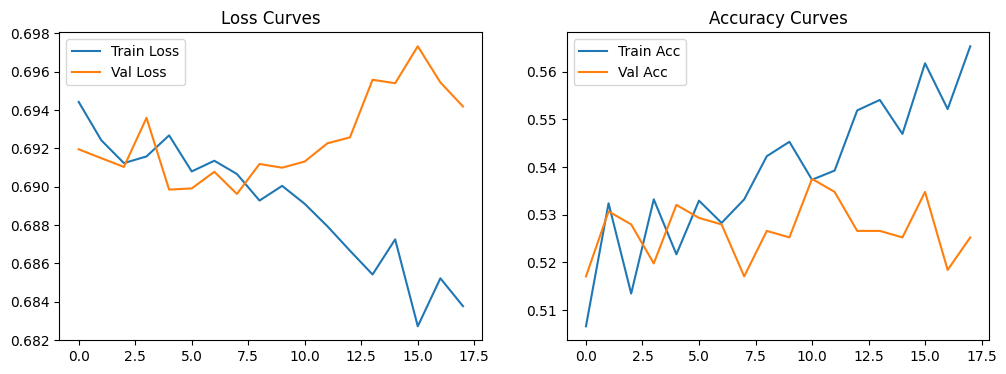

 1/23 ━━━━━━━━━━━━━━━━━━━━ 12s 590ms/step

 5/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step  

 9/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

14/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

18/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step



Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.74      0.63       392
           1       0.49      0.29      0.36       342

    accuracy                           0.53       734
   macro avg       0.52      0.52      0.50       734
weighted avg       0.52      0.53      0.51       734



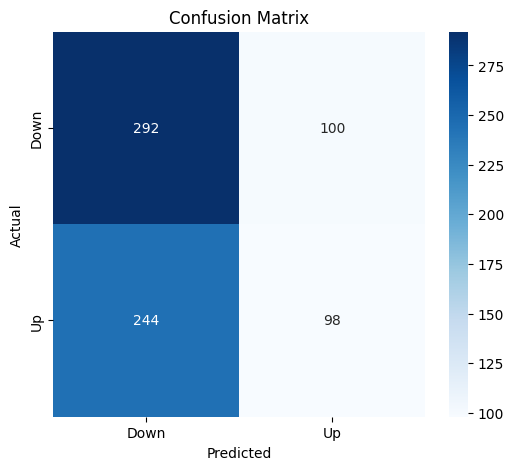

In [7]:
# Plot History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curves')
plt.legend()
plt.show()

# Predictions on Test Set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### 8. Baseline Comparison\nComparing the model's performance against a simple 'Always Up' baseline.

In [8]:
# Baseline Comparison (Always Predict 'Up')
print("Baseline Performance (Always Predict Up):")
baseline_pred = np.ones_like(y_test)
print(classification_report(y_test, baseline_pred))

Baseline Performance (Always Predict Up):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       392
           1       0.47      1.00      0.64       342

    accuracy                           0.47       734
   macro avg       0.23      0.50      0.32       734
weighted avg       0.22      0.47      0.30       734



C:\Users\tanishka\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\tanishka\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\tanishka\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _war

In [9]:
import joblib
import os
# Create model directory if it doesn't exist
os.makedirs('../../model', exist_ok=True)

# Save the final model
model_path = '../../model/crude_cnn_lstm.keras'
model.save(model_path)
print(f"Model saved to {model_path}")

# Save the scaler
scaler_path = '../../model/scaler.joblib'
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to {scaler_path}")

Model saved to ../../model/crude_cnn_lstm.keras
Scaler saved to ../../model/scaler.joblib
